# This is the Langevin simulation for the SFI. We are computing the langevin of a particle in a evanescing potential F_0(1 - e^(-t/tau)) such that the particle goes out from equilibrium and returns to equilibrium in an t>tau time. The thing about the SFI is that to compute it one must be careful about the way of computing the derivatives.

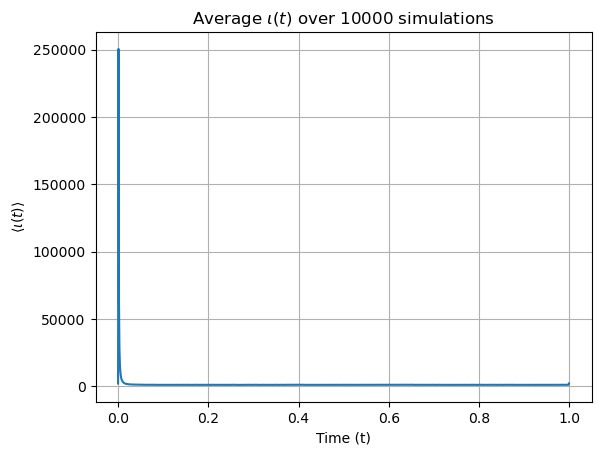

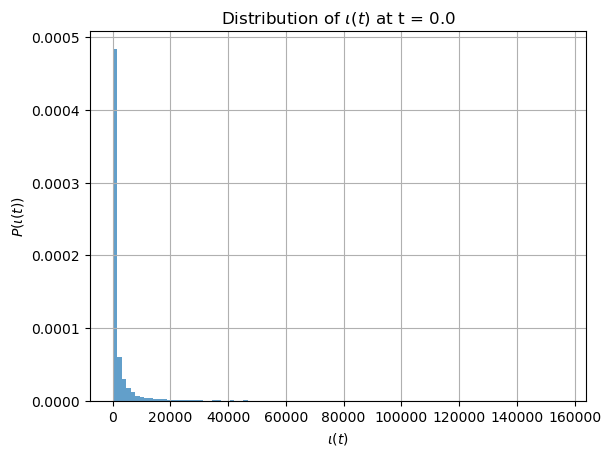

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import jit        

@jit
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, x0):
    # Initialize arrays to store position, work, and time
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(0, num_steps*dt, dt)
    x0 = random.gauss(0, T / k)
    x[0] = x0
    
    # Generate random noise
    dW = np.sqrt(dt) * np.random.normal(0, np.sqrt(2*T))
    
    # Euler-Maruyama method
    for i in range(num_steps-1):
        F = -k * x[i] + F0*(1 - np.exp(-t[i]/tau)) # Deterministic force + Protocol
        stochastic_force = np.sqrt(2 * gamma * T * dt) * np.random.normal()
        x[i+1] = x[i] + (F) * dt + stochastic_force
        Feq = -((F0**2/(2*k))*(np.exp(-t[i+1]/tau) - 1))**2
        work = -((F0/tau)*np.exp(-t[i+1]/tau)*(x[i+1]))
        w[i+1] = w[i] + work * dt #- Feq * dt
    return x, w, t

# Parameters
num_steps = 1000
dt = 0.001
gamma = 0.9999  # Damping coefficient
mass = 1.0
k = 1.0      # Spring constant
T = 1.0      # Temperature
beta = 1/T
x0 = 0.0     # Initial position
F0 = 1.0
tau = 1.0

# Number of simulations to perform
num_simulations = 10000  # Reduced for faster testing

# Arrays to store positions, work, and iota for all times and simulations
positions_all_times = np.zeros((num_simulations, num_steps))
work_all_times = np.zeros((num_simulations, num_steps))
iota_all_times = np.zeros((num_simulations, num_steps))

# Perform multiple simulations
for i in range(num_simulations):
    x, w, t = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, x0)
    positions_all_times[i, :] = x
    work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
    
    # Compute the derivative x'(t) using central difference
    x_derivative = np.zeros(num_steps)
    x_derivative[1:-1] = (x[2:] - x[:-2]) / (2 * dt)  # Central difference for derivative
    
    # Handle boundary points (forward and backward differences)
    x_derivative[0] = (x[1] - x[0]) / dt  # Forward difference at t=0
    x_derivative[-1] = (x[-1] - x[-2]) / dt  # Backward difference at t=end
    
    # Calculate iota(t) for all time steps
    for j in range(num_steps):
        # Handle division by zero in term2 when t[j] = 0
        if t[j] == 0:
            term2 = 0  # Set term2 to 0 or another appropriate value
        else:
            term2 = (k * (gamma - k * tau)**2) / (np.exp(k * t[j] / gamma) - 1)
        
        term1 = 2 * np.exp(-2 * t[j] / tau) * F0**2 * k * beta * gamma * tau
        term3 = (k * (gamma - k * tau)**2) / (np.exp(k * t[j] / gamma) + 1)
        term4 = 2 * np.exp(-t[j] * (k / gamma + 1 / tau)) * k * beta * gamma * (-gamma + k * tau) * x[j] * ((np.exp(k * t[j] / gamma) - np.exp(t[j] / tau)) * F0 + np.exp(t[j] * (k / gamma + 1 / tau)) * (gamma - k * tau) * x_derivative[j])
        term5 = 2 * np.exp(-2 * k * t[j] / gamma) * F0 * beta * gamma * (F0 * gamma + np.exp(2 * k * t[j] / gamma) * (gamma - k * tau)**2 * x_derivative[j] - np.exp(k * t[j] / gamma) * (gamma - k * tau) * (F0 + gamma * x_derivative[j]))
        term6 = 2 * np.exp(-t[j] * (k / gamma + 1 / tau)) * F0 * beta * gamma * (-F0 * (gamma + k * tau) + np.exp(k * t[j] / gamma) * (gamma - k * tau) * (F0 + k * tau * x_derivative[j]))
        
        iota = (term1 + term2 - term3 + term4 + term5 + term6)**2 / (4 * gamma**2 * (gamma - k * tau)**4)
        iota_all_times[i, j] = iota
length_at_all_times = np.zeros((num_simulations,num_steps))
cost_at_all_times = np.zeros((num_simulations,num_steps))
#for i in range(num_steps):
    
# Plot the average iota(t) over all simulations
mean_iota_over_time = np.mean(iota_all_times, axis=0)
plt.plot(t, mean_iota_over_time)
plt.xlabel('Time (t)')
plt.ylabel(r'$\langle \iota(t) \rangle$')  # Use raw string for LaTeX
#plt.yscale('log')
plt.title(r'Average $\iota(t)$ over {} simulations'.format(num_simulations))  # Use raw string for LaTeX
plt.grid(True)
plt.show()

# Plot the distribution of iota(t) at a specific time (e.g., t = 1.0)
specific_time_index = 0#int(1.0 / dt) - 1  # Subtract 1 to ensure it's within bounds
plt.hist(iota_all_times[:, specific_time_index], bins=100, density=True, alpha=0.7)
plt.xlabel(r'$\iota(t)$')  # Use raw string for LaTeX
plt.ylabel(r'$P(\iota(t))$')  # Use raw string for LaTeX
plt.title(r'Distribution of $\iota(t)$ at t = {}'.format(t[specific_time_index]))  # Use raw string for LaTeX
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import jit        

@jit
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, x0):
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(0, num_steps*dt, dt)
    x0 = random.gauss(0, T / k)
    x[0] = x0
    
    for i in range(num_steps-1):
        F = -k * x[i] + F0*(1 - np.exp(-t[i]/tau)) 
        stochastic_force = np.sqrt(2 * gamma * T * dt) * np.random.normal()
        x[i+1] = x[i] + (F) * dt + stochastic_force
        work = -((F0/tau)*np.exp(-t[i+1]/tau)*(x[i+1]))
        w[i+1] = w[i] + work * dt  
    return x, w, t

# Parameters
num_steps = 1000
dt = 0.001
gamma = 0.9999  
k = 1.0     
T = 1.0     
beta = 1/T
x0 = 0.0    
F0 = 1.0
tau = 1.0
num_simulations = 10000  

positions_all_times = np.zeros((num_simulations, num_steps))
work_all_times = np.zeros((num_simulations, num_steps))
iota_all_times = np.zeros((num_simulations, num_steps))
velocity_all_times = np.zeros((num_simulations, num_steps))

for i in range(num_simulations):
    x, w, t = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, x0)
    positions_all_times[i, :] = x
    work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
    
    x_derivative = np.zeros(num_steps)
    x_derivative[1:-1] = (x[2:] - x[:-2]) / (2 * dt)  
    x_derivative[0] = (x[1] - x[0]) / dt  
    x_derivative[-1] = (x[-1] - x[-2]) / dt  

    for j in range(num_steps):
        if t[j] == 0:
            term2 = 0  
        else:
            term2 = (k * (gamma - k * tau)**2) / (np.exp(k * t[j] / gamma) - 1)
        
        term1 = 2 * np.exp(-2 * t[j] / tau) * F0**2 * k * beta * gamma * tau
        term3 = (k * (gamma - k * tau)**2) / (np.exp(k * t[j] / gamma) + 1)
        term4 = (2 * np.exp(-t[j] * (k / gamma + 1 / tau)) * k * beta * gamma *
                 (-gamma + k * tau) * x[j] * ((np.exp(k * t[j] / gamma) - np.exp(t[j] / tau)) * F0 + 
                 np.exp(t[j] * (k / gamma + 1 / tau)) * (gamma - k * tau) * x_derivative[j]))
        term5 = (2 * np.exp(-2 * k * t[j] / gamma) * F0 * beta * gamma *
                 (F0 * gamma + np.exp(2 * k * t[j] / gamma) * (gamma - k * tau)**2 * x_derivative[j] - 
                 np.exp(k * t[j] / gamma) * (gamma - k * tau) * (F0 + gamma * x_derivative[j])))
        term6 = (2 * np.exp(-t[j] * (k / gamma + 1 / tau)) * F0 * beta * gamma *
                 (-F0 * (gamma + k * tau) + np.exp(k * t[j] / gamma) * (gamma - k * tau) * (F0 + k * tau * x_derivative[j])))
        
        iota = (term1 + term2 - term3 + term4 + term5 + term6)**2 / (4 * gamma**2 * (gamma - k * tau)**4)
        iota_all_times[i, j] = iota

        # Compute average velocity using the provided expression
        velocity = (np.exp(-t[j] * (k/gamma + 1/tau)) * k * np.pi *
            (np.cosh(k*t[j]/gamma)**-2 * 
            (4 * F0**2 * beta * gamma**2 - 
            4 * F0**2 * beta * gamma**2 * np.cosh(2*k*t[j]/gamma) + 
            2 * F0**2 * beta * gamma**2 * np.cosh(t[j]*(k/gamma + 1/tau)) + 
            k * gamma**2 * np.cosh(k*t[j]/gamma - t[j]/tau) - 
            4 * F0**2 * beta * gamma**2 * np.cosh(k*t[j]/gamma - t[j]/tau) - 
            2 * k**2 * gamma * tau * np.cosh(k*t[j]/gamma - t[j]/tau) + 
            k**3 * tau**2 * np.cosh(k*t[j]/gamma - t[j]/tau) + 
            2 * F0**2 * beta * gamma**2 * np.cosh(3*k*t[j]/gamma - t[j]/tau) - 
            k * (gamma - k * tau)**2 * np.sinh(k*t[j]/gamma - t[j]/tau)) + 
            4 * beta * gamma**2 * (gamma - k * tau) * x_derivative[j] * 
            (2 * (np.exp((k*t[j])/gamma) - np.exp(t[j]/tau)) * F0 + 
            np.exp(t[j]*(k/gamma + 1/tau)) * (gamma - k * tau) * x_derivative[j])
        ) / (np.sqrt(2) * np.sqrt(k * beta) * gamma**2 * (gamma - k * tau)**2 * np.sqrt(k * beta * (1 + 1/np.tanh(k*t[j]/gamma))))
        
        velocity_all_times[i, j] = velocity

# Compute mean quantities
mean_iota_over_time = np.mean(iota_all_times, axis=0)
mean_velocity_over_time = np.mean(velocity_all_times, axis=0)

# Plot the results
plt.figure(figsize=(10, 5))

# Plot mean iota(t)
plt.subplot(1, 2, 1)
plt.plot(t, mean_iota_over_time, label=r'$\langle \iota(t) \rangle$')
plt.xlabel('Time (t)')
plt.ylabel(r'$\langle \iota(t) \rangle$')
plt.title(r'Average $\iota(t)$ over {} simulations'.format(num_simulations))
plt.grid(True)

# Plot mean velocity(t)
plt.subplot(1, 2, 2)
plt.plot(t, mean_velocity_over_time, label=r'$\langle v(t) \rangle$', color='r')
plt.xlabel('Time (t)')
plt.ylabel(r'$\langle v(t) \rangle$')
plt.title(r'Average Velocity $\langle v(t) \rangle$ over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Optimized Langevin dynamics simulation using Numba for parallel execution"""
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Pre-allocate arrays
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    
    # Initialize with Gaussian distribution
    x[0] = np.random.normal(0, np.sqrt(T / k))
    
    # Pre-compute exponential terms
    exp_terms = np.exp(-t/tau)
    
    # Main simulation loop
    for i in range(num_steps-1):
        F = -k * x[i] + F0 * (1 - exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T * dt) * np.random.normal()
        x[i+1] = x[i] + F * dt + stochastic_force
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    # Central difference for interior points
    x_derivative[1:-1] = (x[2:] - x[:-2]) / (2 * dt)
    # Forward/backward difference for endpoints
    x_derivative[0] = (x[1] - x[0]) / dt
    x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value optimized with Numba"""
    num_steps = len(t)
    beta = 1/T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        # Main calculation
        terma = 2 * np.exp(-((2 * t) / tau)) * F0**2 * k * beta * gamma * tau
        termb = (k * (gamma - k * tau)**2) / (-1 + np.exp((k * t) / gamma))
        termc = -(k * (gamma - k * tau)**2) / (1 + np.exp((k * t) / gamma))    
        termd = 2 * np.exp(-t * (k / gamma + 1 / tau)) * k * beta * gamma * (-gamma + k * tau) * x[j] * (
            (np.exp((k * t) / gamma) - np.exp(t / tau)) * F0 + np.exp(t * (k / gamma + 1 / tau)) * (gamma - k * tau) * x_derivative[j])
        terme = 2 * np.exp(-((2 * k * t) / gamma)) * F0 * beta * gamma * (
            F0 * gamma + np.exp((2 * k * t) / gamma) * (gamma - k * tau)**2 * x_derivative[j] -
            np.exp((k * t) / gamma) * (gamma - k * tau) * (F0 + gamma * x_derivative[j])
        )
        termf = 2 * np.exp(-t * (k / gamma + 1 / tau)) * F0 * beta * gamma * (
            -F0 * (gamma + k * tau) + np.exp((k * t) / gamma) * (gamma - k * tau) * (F0 + k * tau * x_derivative[j])
        )
    
        iota[j] = term1 * (terma + termb + termc + termd + terme + termf)**2
        
    return iota

@jit(nopython=True)
def calculate_I(t, mean_x_derivative, gamma, k, tau, F0, beta):
    """Calculate I(t) optimized with Numba"""
    result = np.zeros_like(t)
    
    for i in range(len(t)):
        ti = t[i]
        x_deriv = mean_x_derivative[i]
        
        term1 = np.exp(-ti * (k/gamma + 1/tau)) * k * np.pi
        
        # Avoid expensive repeated calculations
        exp_kt_gamma = np.exp(k*ti/gamma)
        cosh_kt_gamma = 0.5 * (exp_kt_gamma + 1/exp_kt_gamma)
        cosh_2kt_gamma = 0.5 * (np.exp(2*k*ti/gamma) + np.exp(-2*k*ti/gamma))
        cosh_kt_gamma_minus_t_tau = 0.5 * (np.exp(k*ti/gamma - ti/tau) + np.exp(-(k*ti/gamma - ti/tau)))
        cosh_3kt_gamma_minus_t_tau = 0.5 * (np.exp(3*k*ti/gamma - ti/tau) + np.exp(-(3*k*ti/gamma - ti/tau)))
        cosh_t_k_gamma_plus_1_tau = 0.5 * (np.exp(ti*(k/gamma + 1/tau)) + np.exp(-ti*(k/gamma + 1/tau)))
        sinh_kt_gamma_minus_t_tau = 0.5 * (np.exp(k*ti/gamma - ti/tau) - np.exp(-(k*ti/gamma - ti/tau)))
        
        term2 = (1/cosh_kt_gamma**2) * (
            4 * F0**2 * beta * gamma**2 - 
            4 * F0**2 * beta * gamma**2 * cosh_2kt_gamma + 
            2 * F0**2 * beta * gamma**2 * cosh_t_k_gamma_plus_1_tau + 
            k * gamma**2 * cosh_kt_gamma_minus_t_tau - 
            4 * F0**2 * beta * gamma**2 * cosh_kt_gamma_minus_t_tau - 
            2 * k**2 * gamma * tau * cosh_kt_gamma_minus_t_tau + 
            k**3 * tau**2 * cosh_kt_gamma_minus_t_tau + 
            2 * F0**2 * beta * gamma**2 * cosh_3kt_gamma_minus_t_tau - 
            k * (gamma - k * tau)**2 * sinh_kt_gamma_minus_t_tau
        )
        
        term3 = (
            4 * beta * gamma**2 * (gamma - k * tau) * x_deriv * 
            (2 * (exp_kt_gamma - np.exp(ti/tau)) * F0 + 
             np.exp(ti*(k/gamma + 1/tau)) * (gamma - k * tau) * x_deriv)
        )
        
        tanh_kt_gamma = (exp_kt_gamma - 1/exp_kt_gamma) / (exp_kt_gamma + 1/exp_kt_gamma)
        denominator = (
            np.sqrt(2) * np.sqrt(k * beta) * gamma**2 * (gamma - k * tau)**2 * 
            np.sqrt(k * beta * (1 + 1/tanh_kt_gamma))
        )
        
        result[i] = (term1 * (term2 + term3)) / denominator
        
    return result

def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100  # Process in smaller batches to avoid memory issues
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        batch_count = end_idx - batch
        
        for i in range(batch, end_idx):
            # Use different seed for each simulation
            x, w, _ = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
            
            # Calculate derivatives
            x_derivative_all_times[i, :] = calculate_derivatives(x, dt, num_steps)
            
            # Calculate iota
            iota_all_times[i, :] = calculate_iota(x, x_derivative_all_times[i, :], t, gamma, k, T, F0, tau)
            
            # Print progress every 1000 simulations
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    # Compute mean quantities
    mean_iota_over_time = np.mean(iota_all_times, axis=0)
    mean_x_derivative_over_time = np.mean(x_derivative_all_times, axis=0)
    # Compute I(t)
    beta = 1/T
    I_t = calculate_I(t, mean_x_derivative_over_time, gamma, k, tau, F0, beta)
    
    return t, mean_iota_over_time, I_t, iota_all_times
    
def plot_results(t, mean_iota_over_time, I_t, iota_all_times, specific_time_index):
    """Plot results with improved formatting"""
    plt.figure(figsize=(10, 6))
    plt.plot(t, np.sqrt(mean_iota_over_time), label=r'$\langle \iota(t) \rangle$', linewidth=2)
    plt.plot(t, I_t, label=r'$I(t)$', linestyle='--', linewidth=2)
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.yscale('log')
    plt.ylim(10**(-6),10)
    plt.title(r'Average $\iota(t)$ and $I(t)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Create second figure for histogram
    plt.figure(figsize=(10, 6))
    plt.hist(iota_all_times[:, specific_time_index], bins=100, density=True, alpha=0.7)
    plt.xlabel(r'$\iota(t)$', fontsize=12)
    plt.ylabel(r'$P(\iota(t))$', fontsize=12)
    plt.title(r'Distribution of $\iota(t)$ at t = {:.3f}'.format(t[specific_time_index]), fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 1000
    dt = 0.001
    gamma = 0.8
    k = 1.0
    T = .9
    x0 = 0.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000  # Can be reduced for testing
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    t, mean_iota, I_t, iota_all = run_simulations(
        num_simulations, num_steps, dt, gamma, F0, tau, k, T
    )
    # Choose a specific time index for histogram
    specific_time_index = int(1)  # For t = 0.001
    if specific_time_index >= num_steps:
        specific_time_index = 1  # Default to second time step if out of range
    
    # Plot results
    plot_results(t, mean_iota, I_t, iota_all, specific_time_index)

Starting 10000 Langevin simulations...


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
      - Of which 16 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 1d, C), int64, array(float64, 1d, C))':
       No match.

During: typing of setitem at /tmp/ipykernel_192526/3707790471.py (65)

File "../../tmp/ipykernel_192526/3707790471.py", line 65:
<source missing, REPL/exec in use?>


Starting 10000 Langevin simulations...
Completed 0/10000 simulations
Completed 1000/10000 simulations
Completed 2000/10000 simulations
Completed 3000/10000 simulations
Completed 4000/10000 simulations
Completed 5000/10000 simulations
Completed 6000/10000 simulations
Completed 7000/10000 simulations
Completed 8000/10000 simulations
Completed 9000/10000 simulations


/tmp/ipykernel_5079/2046612345.py:210: RuntimeWarning: invalid value encountered in divide
  ratio = length**2 / (deviation)
/tmp/ipykernel_5079/2046612345.py:211: RuntimeWarning: invalid value encountered in divide
  ratio2 = length2**2 / (deviation2)


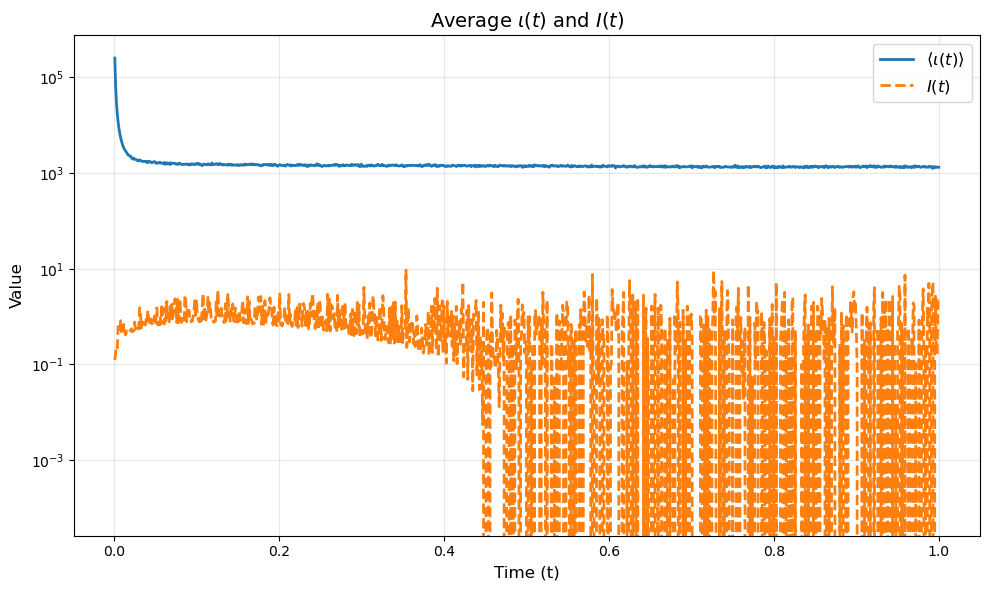

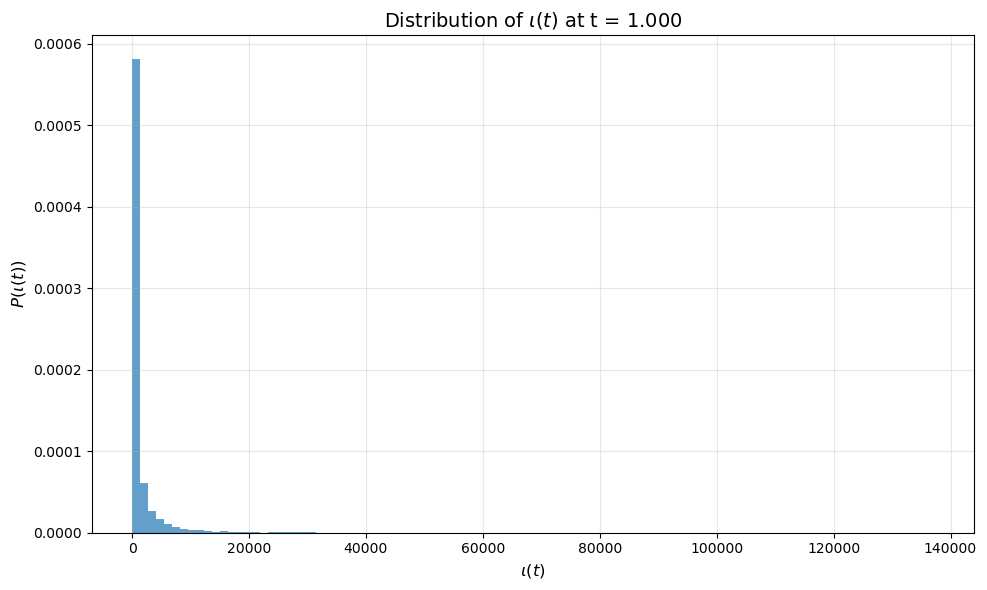

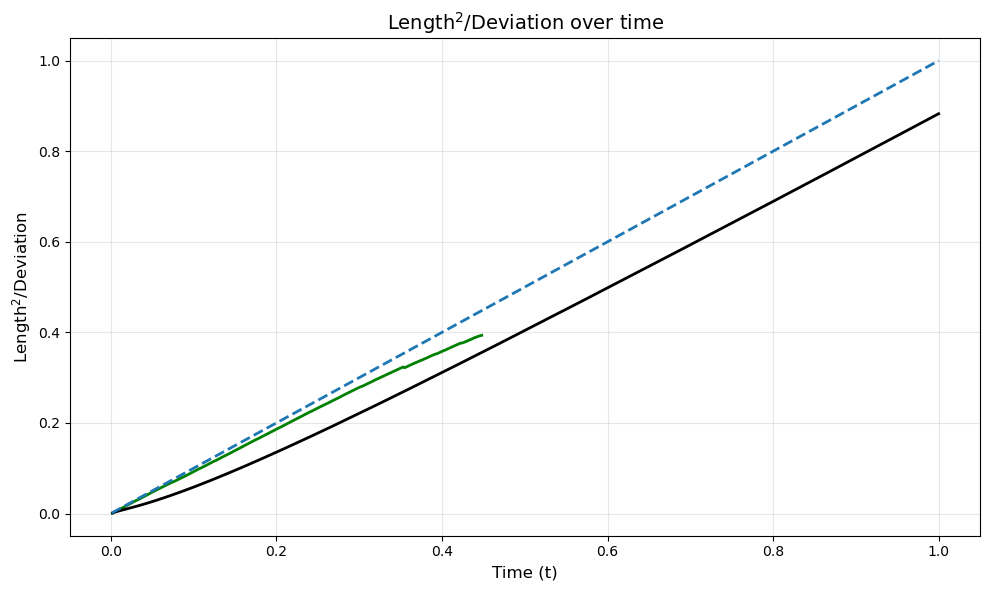

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Optimized Langevin dynamics simulation using Numba for parallel execution"""
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Pre-allocate arrays
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    
    # Initialize with Gaussian distribution
    x[0] = np.random.normal(0, np.sqrt(T / k))
    
    # Pre-compute exponential terms
    exp_terms = np.exp(-t/tau)
    
    # Main simulation loop
    for i in range(num_steps-1):
        F = -k * x[i] + F0 * (1 - exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T * dt) * np.random.normal()
        x[i+1] = x[i] + F * dt + stochastic_force
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    for i in range(0,num_steps-1):
    # Central difference for interior points
        x_derivative[i] = (x[i+1] - x[i]) / (dt)
    # Forward/backward difference for endpoints
    x_derivative[-1] = (x[-1] - x[-2]) / dt
    #x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative
@jit(nopython=True)
def term1(t, k, gamma, tau, beta, F0):
    term1 = np.exp(-2 * t * (k / gamma + 1 / tau))
    coth_term = np.cosh(k * t / gamma) / np.sinh(k * t / gamma) - 1
    
    exp_term1 = np.exp(2 * t * (k / gamma + 1 / tau)) * (gamma**2 * (beta * F0**2 + k) + k**3 * tau**2 - 2 * gamma * k**2 * tau)
    exp_term2 = -beta * gamma * F0**2 * k * tau * np.exp(2 * k * t / gamma)
    exp_term3 = beta * gamma * F0**2 * k * tau * np.exp(4 * k * t / gamma)
    exp_term4 = -beta * gamma * F0**2 * (gamma - k * tau) * np.exp(t * (2 * k / gamma + 1 / tau))
    exp_term5 = beta * gamma * F0**2 * (gamma - k * tau) * np.exp(t * (4 * k / gamma + 1 / tau))
    exp_term6 = beta * gamma * F0**2 * (gamma - k * tau) * np.exp(k * t / gamma + 2 * t / tau)
    exp_term7 = -beta * gamma * F0**2 * (gamma - k * tau) * np.exp(3 * k * t / gamma + 2 * t / tau)
    exp_term8 = beta * gamma * F0**2 * (gamma + k * tau) * np.exp(t * (k / gamma + 1 / tau))
    exp_term9 = -beta * gamma * F0**2 * (gamma + k * tau) * np.exp(t * (3 * k / gamma + 1 / tau))
    exp_term10 = -beta * gamma**2 * F0**2 * np.exp(2 * t / tau)
    
    numerator = term1 * coth_term * (exp_term1 + exp_term2 + exp_term3 + exp_term4 + exp_term5 + 
                                    exp_term6 + exp_term7 + exp_term8 + exp_term9 + exp_term10)
    denominator = 2 * gamma * (gamma - k * tau)**2
    terma = numerator / denominator
    return terma

@jit(nopython=True)
def term2(t, k, gamma, tau, beta, F0):
    term = beta * F0 * (gamma + gamma * (-np.exp(-k * t / gamma)) + k * tau * (np.exp(-t / tau) - 1))
    return term

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value optimized with Numba"""
    num_steps = len(t)
    beta = 1/T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        # Main calculation
        a = term1(t[j], k, gamma, tau, beta, F0)
        c = term2(t[j], k, gamma, tau, beta, F0)
        b = (1 / (gamma - k*tau)) * (c*x_derivative[j] + k*beta*x[j]*(np.exp(-k*tau/gamma) * F0 + (-gamma + k*tau)*x_derivative[j]))
        iota[j] = (a + b)**2
        
    return iota

@jit(nopython=True)
def calculate_I(t, mean_x_derivative, gamma, k, tau, F0, beta):
    """Calculate I(t) optimized with Numba"""
    result = np.zeros_like(t)
    
    for i in range(len(t)):
        ti = t[i]
        x_deriv = mean_x_derivative[i]
        
        term1 = np.exp(-ti * (k/gamma + 1/tau)) * k * np.pi
        
        # Avoid expensive repeated calculations
        exp_kt_gamma = np.exp(k*ti/gamma)
        cosh_2kt_gamma = 0.5 * (np.exp(2*k*ti/gamma) + np.exp(-2*k*ti/gamma))
        cosh_kt_gamma_minus_t_tau = 0.5 * (np.exp(k*ti/gamma - ti/tau) + np.exp(-(k*ti/gamma - ti/tau)))
        cosh_3kt_gamma_minus_t_tau = 0.5 * (np.exp(3*k*ti/gamma - ti/tau) + np.exp(-(3*k*ti/gamma - ti/tau)))
        cosh_t_k_gamma_plus_1_tau = 0.5 * (np.exp(ti*(k/gamma + 1/tau)) + np.exp(-ti*(k/gamma + 1/tau)))
        sinh_kt_gamma_minus_t_tau = 0.5 * (np.exp(k*ti/gamma - ti/tau) - np.exp(-(k*ti/gamma - ti/tau)))
        
        term2 = (1 / (0.5*(np.exp(k*ti/gamma) + 1/np.exp(k*ti/gamma)))**2) 
        term2 *= (4 * F0**2 * beta * gamma**2 - 4 * F0**2 * beta * gamma**2 * cosh_2kt_gamma + 2 * F0**2 * beta * gamma**2 * cosh_t_k_gamma_plus_1_tau +k * gamma**2 * cosh_kt_gamma_minus_t_tau - 4 * F0**2 * beta * gamma**2 * cosh_kt_gamma_minus_t_tau - 2 * k**2 * gamma * tau * cosh_kt_gamma_minus_t_tau + k**3 * tau**2 * cosh_kt_gamma_minus_t_tau + 2 * F0**2 * beta * gamma**2 * cosh_3kt_gamma_minus_t_tau - k * (gamma - k * tau)**2 * sinh_kt_gamma_minus_t_tau)
        term3 = (4 * beta * gamma**2 * (gamma - k * tau) * x_deriv * (2 * (exp_kt_gamma - np.exp(ti/tau)) * F0 + np.exp(ti*(k/gamma + 1/tau)) * (gamma - k * tau) * x_deriv))
        
        tanh_kt_gamma = (exp_kt_gamma - 1/exp_kt_gamma) / (exp_kt_gamma + 1/exp_kt_gamma)
        denominator = (np.sqrt(2) * np.sqrt(k * beta) * gamma**2 *(gamma - k * tau)**2 * np.sqrt(k * beta * (1 + 1/tanh_kt_gamma)))
        
        result[i] = (term1 * (term2 + term3)) / denominator
        
    return result

@jit(nopython=True)
def calculate_integrals(t, I_t, dt):
    """Calculate the length and deviation integrals"""
    num_steps = len(t)
    length = np.zeros(num_steps)
    deviation = np.zeros(num_steps)
    
    # Calculate cumulative integrals
    for i in range(1, num_steps):
        # Trapezoidal rule integration for length (sqrt of I_t)
        length[i] = length[i-1] + 0.5 * dt * (np.sqrt(I_t[i]) + np.sqrt(I_t[i-1]))
        
        # Trapezoidal rule integration for deviation (I_t)
        deviation[i] = deviation[i-1] + 0.5 * dt * (I_t[i] + I_t[i-1])
    
    return length, deviation

def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100  # Process in smaller batches to avoid memory issues
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        batch_count = end_idx - batch
        
        for i in range(batch, end_idx):
            # Use different seed for each simulation
            x, w, _ = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
            
            # Calculate derivatives
            x_derivative_all_times[i, :] = calculate_derivatives(x, dt, num_steps)
            
            # Calculate iota
            iota_all_times[i, :] = calculate_iota(x, x_derivative_all_times[i, :], t, gamma, k, T, F0, tau)
            
            # Print progress every 1000 simulations
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    
    # Compute mean quantities
    mean_iota_over_time = np.mean(iota_all_times, axis=0)
    mean_x_over_time = np.mean(positions_all_times, axis=0)
    mean_x_derivative_over_time = calculate_derivatives(mean_x_over_time, dt, num_steps)
    # Compute I(t)
    beta = 1/T
    I_t = calculate_I(t, mean_x_derivative_over_time, gamma, k, tau, F0, beta)
    
    # Calculate length and deviation
    length, deviation = calculate_integrals(t, I_t, dt)
    length2, deviation2 = calculate_integrals(t,mean_iota_over_time, dt)
    return t, mean_iota_over_time, I_t, iota_all_times, length, deviation, length2, deviation2
    
def plot_results(t, mean_iota_over_time, I_t, iota_all_times, length, deviation, specific_time_index, length2, deviation2):
    """Plot results with improved formatting"""
    # Plot 1: Mean iota and I(t)
    plt.figure(figsize=(10, 6))
    plt.plot(t, mean_iota_over_time, label=r'$\langle \iota(t) \rangle$', linewidth=2)
    plt.plot(t, I_t, label=r'$I(t)$', linestyle='--', linewidth=2)
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.yscale('log')
    #plt.ylim(10**(-6),10)
    plt.title(r'Average $\iota(t)$ and $I(t)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('avgs.pdf',dpi=700)
    plt.tight_layout()
    
    # Plot 2: Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(iota_all_times[:, specific_time_index], bins=100, density=True, alpha=0.7)
    plt.xlabel(r'$\iota(t)$', fontsize=12)
    plt.ylabel(r'$P(\iota(t))$', fontsize=12)
    plt.title(r'Distribution of $\iota(t)$ at t = {:.3f}'.format(t[specific_time_index]), fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig('histogram_sfi_iota_attime.pdf',dpi=700)
    plt.tight_layout()
    
    # Plot 3: Length^2/Deviation
    plt.figure(figsize=(10, 6))
    # Avoid division by zero by adding a small epsilon
    epsilon = 0.001
    ratio = length**2 / (deviation)
    ratio2 = length2**2 / (deviation2)
    plt.plot(t, ratio, linewidth=2, color='green')
    plt.plot(t, ratio2, linewidth=2, color='black')
    plt.plot(t,t, linestyle='--',linewidth=2)
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel(r'$\mathrm{Length}^2 / \mathrm{Deviation}$', fontsize=12)
    plt.title(r'$\mathrm{Length}^2 / \mathrm{Deviation}$ over time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comp_ito.pdf',dpi=700)
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 1000
    dt = 0.001
    gamma = 0.8
    k = 1.0
    T = .9
    x0 = 0.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000  # Can be reduced for testing
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    t, mean_iota, I_t, iota_all, length, deviation, length2, deviation2 = run_simulations(
        num_simulations, num_steps, dt, gamma, F0, tau, k, T
    )
    # Choose a specific time index for histogram
    specific_time_index = int(num_steps-1)  # For t = 0.001
    if specific_time_index >= num_steps:
        specific_time_index = num_steps  # Default to second time step if out of range
    
    # Plot results
    plot_results(t, mean_iota, I_t, iota_all, length, deviation, specific_time_index, length2, deviation2)

Starting 10000 Langevin simulations...
Completed 0/10000 simulations
Completed 1000/10000 simulations
Completed 2000/10000 simulations
Completed 3000/10000 simulations
Completed 4000/10000 simulations
Completed 5000/10000 simulations
Completed 6000/10000 simulations
Completed 7000/10000 simulations
Completed 8000/10000 simulations
Completed 9000/10000 simulations
[2452.09683385 2451.95971403 2449.95684613 ... 2450.4674244  2450.8254511
 2449.86042632]
[1.73112649e+03 5.97418734e+02 3.17596457e+02 2.01576077e+02
 1.41020395e+02 1.04942857e+02 8.15095401e+01 6.53321367e+01
 5.36453973e+01 4.49009709e+01 3.81722810e+01 3.28749492e+01
 2.86244049e+01 2.51584939e+01 2.22931362e+01 1.98958115e+01
 1.78689500e+01 1.61393901e+01 1.46513140e+01 1.33615201e+01
 1.22360817e+01 1.12481884e+01 1.03761066e+01 9.60239587e+00
 8.91284589e+00 8.29554511e+00 7.74073628e+00 7.24023063e+00
 6.78724534e+00 6.37581840e+00 6.00095553e+00 5.65855394e+00
 5.34488947e+00 5.05686502e+00 4.79173319e+00 4.54693199

/tmp/ipykernel_145175/220115935.py:208: RuntimeWarning: invalid value encountered in divide
  ratio = length**2 / (deviation)
/tmp/ipykernel_145175/220115935.py:209: RuntimeWarning: invalid value encountered in divide
  ratio2 = length2**2 / (deviation2)


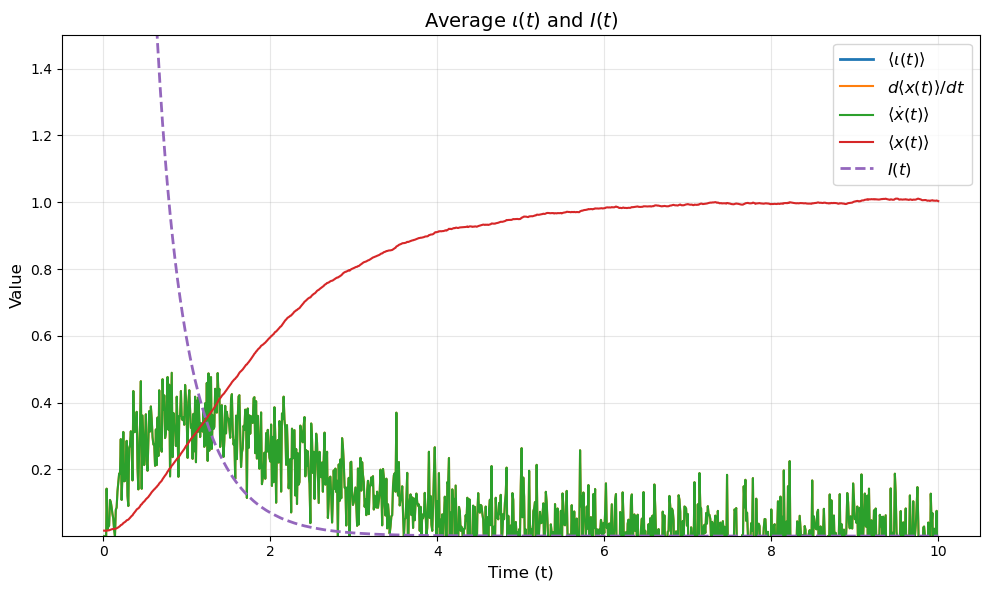

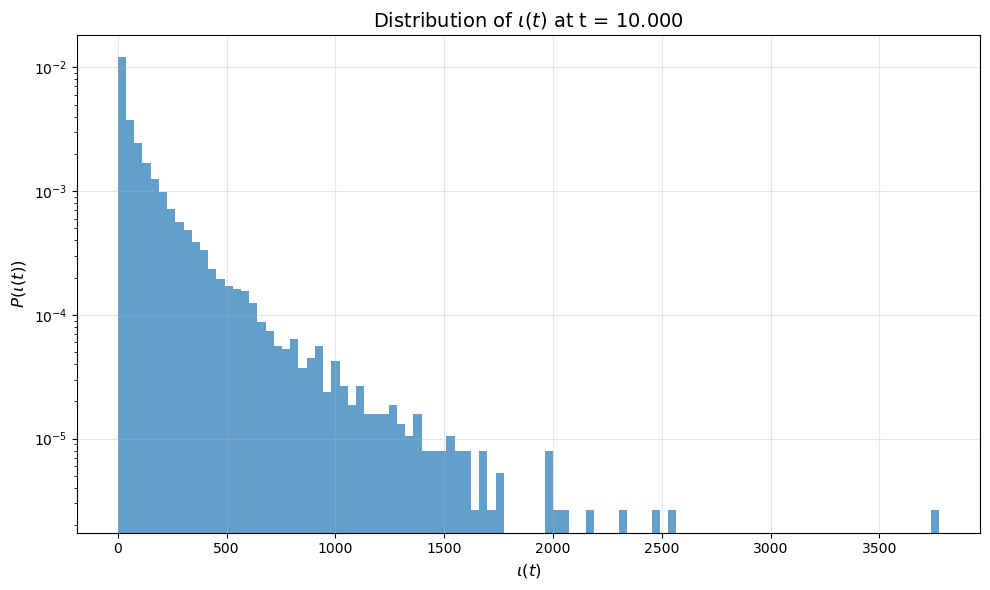

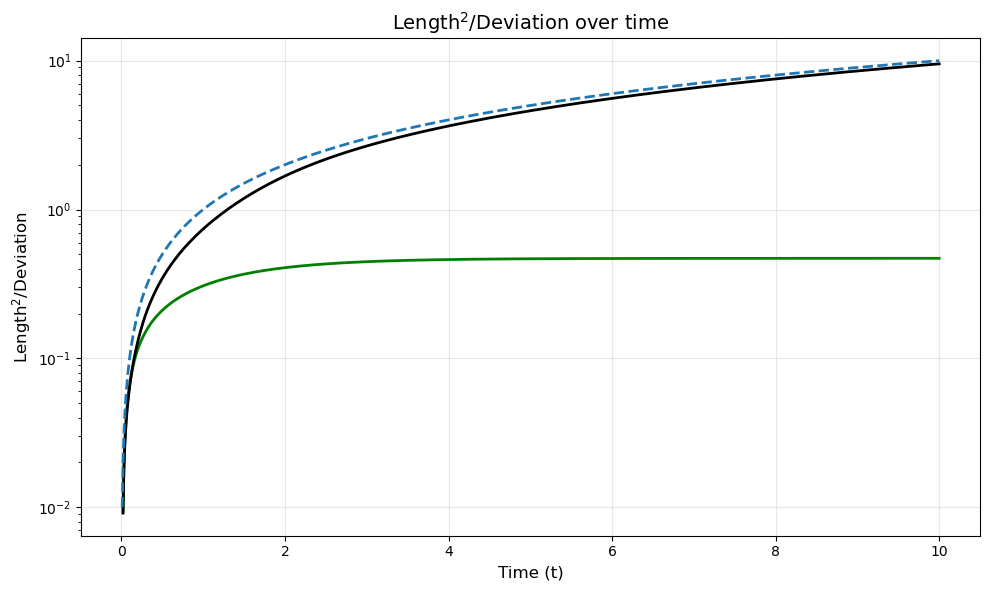

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as sts
from numba import jit, prange

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Langevin dynamics simulation using 4th-order Runge-Kutta method"""
    np.random.seed(seed)
    
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    dx_dt = np.zeros(num_steps)
    
    x[0] = np.random.normal(0, np.sqrt(T / k))
    exp_terms = np.exp(-t/tau)
    
    def langevin_force(x, i):
        deterministic_force = -k * x + F0 * (1 - exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T / dt) * np.random.normal()
        return deterministic_force + stochastic_force
    
    for i in range(num_steps - 1):
        k1 = dt * langevin_force(x[i], i)
        k2 = dt * langevin_force(x[i] + 0.5 * k1, i)
        k3 = dt * langevin_force(x[i] + 0.5 * k2, i)
        k4 = dt * langevin_force(x[i] + k3, i)
        x[i + 1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
        dx_dt[i + 1] = (k1 + 2*k2 + 2*k3 + k4) / (6 * dt)
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t, dx_dt

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    for i in range(1,num_steps):
    # Central difference for interior points
        x_derivative[i] = (x[i] - x[i-1]) / (dt)
    # Forward/backward difference for endpoints
    x_derivative[0] = (x[1] - x[0]) / dt
    #x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value optimized with Numba"""
    num_steps = len(t)
    beta = 1/T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        # Main calculation
        exp = np.exp
        coth = lambda x: 1 / np.tanh(x)  # Hyperbolic cotangent
        ti = t[j]
        term1 = 0
        term2 = 0
        term3 = 0
        term4 = 0
        term1 = (F0**2 * beta**2 * (-np.exp(-k * ti / gamma) * gamma + gamma + (-1 + np.exp(-ti / tau)) * k * tau)**2 * x_derivative[j]**2) / (gamma - k * tau)**2
        term2 = x[j]**2 * (((np.exp(-k * ti / gamma) - np.exp(-ti / tau)) * F0 * k * beta / (gamma - k * tau) - (np.exp(2 * ti * (k / gamma + 1 / tau) - 2 * ti / tau) * k**2 * beta * x_derivative[j]) /((-1 + np.exp(2 * k * ti / gamma)) * k + k))**2)
        term3 = (k * beta * x[j] * ((np.exp(-k * ti / gamma) - np.exp(-ti / tau)) * F0 / (gamma - k * tau) - x_derivative[j]) *(np.exp(-2 * ti * (k / gamma + 1 / tau)) *(-np.exp(2 * ti / tau) * beta * gamma**2 * F0**2 -np.exp(2 * k * ti / gamma) * k * beta * gamma * tau * F0**2 +np.exp(4 * k * ti / gamma) * k * beta * gamma * tau * F0**2 -np.exp(ti * (2 * k / gamma + 1 / tau)) * beta * gamma * (gamma - k * tau) * F0**2 +np.exp(ti * (4 * k / gamma + 1 / tau)) * beta * gamma * (gamma - k * tau) * F0**2 +np.exp(k * ti / gamma + 2 * ti / tau) * beta * gamma * (gamma - k * tau) * F0**2 -np.exp(3 * k * ti / gamma + 2 * ti / tau) * beta * gamma * (gamma - k * tau) * F0**2 +np.exp(ti * (k / gamma + 1 / tau)) * beta * gamma * (gamma + k * tau) * F0**2 -np.exp(ti * (3 * k / gamma + 1 / tau)) * beta * gamma * (gamma + k * tau) * F0**2 +np.exp(2 * ti * (k / gamma + 1 / tau)) * (tau**2 * k**3 - 2 * gamma * tau * k**2 +(beta * F0**2 + k) * gamma**2)) *(coth(k * ti / gamma) - 1)) / gamma +2 * F0 * beta * (gamma - k * tau) *(-np.exp(-k * ti / gamma) * gamma + gamma + (-1 + np.exp(-ti / tau)) * k * tau) *x_derivative[j]) / (gamma - k * tau)**2
        term4 = (np.exp(-4 * ti * (k / gamma + 1 / tau)) * (coth(k * ti / gamma) - 1) * ((coth(k * ti / gamma) - 1) * (np.exp(2 * ti / tau) * beta * gamma**2 * F0**2 + np.exp(2 * k * ti / gamma) * k * beta * gamma * tau * F0**2 - np.exp(4 * k * ti / gamma) * k * beta * gamma * tau * F0**2 + np.exp(ti * (2 * k / gamma + 1 / tau)) * beta * gamma * (gamma - k * tau) * F0**2 - np.exp(ti * (4 * k / gamma + 1 / tau)) * beta * gamma * (gamma - k * tau) * F0**2 - np.exp(k * ti / gamma + 2 * ti / tau) * beta * gamma * (gamma - k * tau) * F0**2 + np.exp(3 * k * ti / gamma + 2 * ti / tau) * beta * gamma * (gamma - k * tau) * F0**2 - np.exp(ti * (k / gamma + 1 / tau)) * beta * gamma * (gamma + k * tau) * F0**2 + np.exp(ti * (3 * k / gamma + 1 / tau)) * beta * gamma * (gamma + k * tau) * F0**2 - np.exp(2 * ti * (k / gamma + 1 / tau)) * (tau**2 * k**3 - 2 * gamma * tau * k**2 + (beta * F0**2 + k) * gamma**2))**2 + 4 * np.exp(2 * ti * (k / gamma + 1 / tau)) * F0 * beta * gamma * (gamma - k * tau) * (-np.exp(-k * ti / gamma) * gamma + gamma + (-1 + np.exp(-ti / tau)) * k * tau) * (-np.exp(2 * ti / tau) * beta * gamma**2 * F0**2 - np.exp(2 * k * ti / gamma) * k * beta * gamma * tau * F0**2 + np.exp(4 * k * ti / gamma) * k * beta * gamma * tau * F0**2 - np.exp(ti * (2 * k / gamma + 1 / tau)) * beta * gamma * (gamma - k * tau) * F0**2 + np.exp(ti * (4 * k / gamma + 1 / tau)) * beta * gamma * (gamma - k * tau) * F0**2 + np.exp(k * ti / gamma + 2 * ti / tau) * beta * gamma * (gamma - k * tau) * F0**2 - np.exp(3 * k * ti / gamma + 2 * ti / tau) * beta * gamma * (gamma - k * tau) * F0**2 + np.exp(ti * (k / gamma + 1 / tau)) * beta * gamma * (gamma + k * tau) * F0**2 - np.exp(ti * (3 * k / gamma + 1 / tau)) * beta * gamma * (gamma + k * tau) * F0**2 + np.exp(2 * ti * (k / gamma + 1 / tau)) * (tau**2 * k**3 - 2 * gamma * tau * k**2 + (beta * F0**2 + k) * gamma**2)) * x_derivative[j])) / (4 * gamma**2 * (gamma - k * tau)**4)
        iota[j] = np.abs(term2 + term3 + term4 + term1)
    return iota

@jit(nopython=True)
def calculate_I(t, mean_x_derivative, gamma, k, tau, F0, beta):
    """Calculate I(t) optimized with Numba"""
    result = np.zeros_like(t)
    coth = lambda x: 1 / np.tanh(x)  # Hyperbolic cotangent
    
    for i in range(len(t)):
        ti = t[i]
        x_deriv = mean_x_derivative[i]
        numerator = 2*np.sqrt(2)*np.exp((k*ti/gamma) - (ti/tau))*k*np.pi
        numerator_1 = (4*F0**2 * beta * gamma**2 * (1 - np.cosh(2*k*ti/gamma) - np.cosh((k*ti/gamma) - (ti/tau))))
        numerator_2 = (2 * F0**2 * gamma**2 * (np.cosh(ti*((k / gamma) - (1 / tau))) - np.cosh((3*k*ti/gamma) -(ti/tau))))
        numerator_3 = (k*(gamma**2) * np.cosh((k*ti/gamma) - (ti/tau))) - (2 * (k**2) * gamma * tau * np.cosh((k*ti/gamma) - (ti/tau))) + (k**3 * tau**2*np.cosh((k*ti/gamma) - (ti/tau))) - (k*(gamma - k*tau)**2 *np.sinh((k*ti/gamma) - (ti/tau)))
        numerator = numerator*(numerator_1 + numerator_2 + numerator_3)
        denominator = ((-1 + np.exp(2*k*ti/gamma))**2 * np.sqrt(k*beta)*gamma**2 *(gamma - k*tau)**2 *np.sqrt(k*beta * (1 + coth(k*ti/gamma))))
        a = 32*np.sqrt(2)*np.exp((-4*k*ti/gamma) + 0.5*ti*((15*k/gamma) - 1/tau))*F0*k*np.pi*beta*np.sinh(0.5*ti*((k/gamma) - (1/tau)))*x_deriv 
        a /= denominator*(1 + coth(k*ti/gamma))**2 / (gamma**2)
        b = 8*np.sqrt(2)*np.exp(4*k*ti/gamma)*k*np.pi*beta*x_deriv**2
        b /= denominator*(1 + coth(k*ti/gamma))**2 / (gamma**2 *(gamma - k*tau)**2)
        result[i] = np.abs(((numerator/denominator) + a + b))
    return result

@jit(nopython=True)
def calculate_integrals(t, I_t, dt):
    """Calculate the length and deviation integrals"""
    num_steps = len(t)
    length = np.zeros(num_steps)
    deviation = np.zeros(num_steps)
    
    # Calculate cumulative integrals
    for i in range(1, num_steps):
        # Trapezoidal rule integration for length (sqrt of I_t)
        length[i] = length[i-1] + 0.5 * dt * (np.sqrt(I_t[i]) + np.sqrt(I_t[i-1]))
        
        # Trapezoidal rule integration for deviation (I_t)
        deviation[i] = deviation[i-1] + 0.5 * dt * (I_t[i] + I_t[i-1])
    
    return length, deviation

def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    mean_iota_over_time = np.zeros(num_steps)
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100  # Process in smaller batches to avoid memory issues
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        batch_count = end_idx - batch
        
        for i in range(batch, end_idx):
            # Use different seed for each simulation
            x, w, _, dx_dt = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
            
            # Calculate derivatives
            x_derivative_all_times[i, :] = dx_dt
            
            # Calculate iota
            iota_all_times[i, :] = calculate_iota(x, x_derivative_all_times[i, :], t, gamma, k, T, F0, tau)
            
            # Print progress every 1000 simulations
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    # Compute weighted mean iota over time using probability distributions
    num_bins = 120  # Number of bins for creating probability distribution
    for j in range(num_steps):
        # Get all iota values at time step j
        iota_values = iota_all_times[:, j]
        
        # Create histogram (probability distribution)
        hist, bin_edges = np.histogram(iota_values, bins=num_bins, density=True)
        
        # Calculate bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Calculate weighted average (expectation value)
        mean_iota_over_time[j] = np.sum(bin_centers * hist) * (bin_edges[1] - bin_edges[0])#np.mean(iota_all_times, axis=0)
    
    # Compute other mean quantities
    mean_x_over_time = np.mean(positions_all_times, axis=0)
    x_mean_over_deriv_time = np.mean(x_derivative_all_times, axis=0)
    mean_x_derivative_over_time = calculate_derivatives(mean_x_over_time, dt, num_steps)
    
    # Compute I(t)
    beta = 1/T
    I_t = calculate_I(t, x_mean_over_deriv_time, gamma, k, tau, F0, beta)/(5*num_simulations*100)
    # Calculate length and deviation
    length, deviation = calculate_integrals(t, I_t, dt)
    length2, deviation2 = calculate_integrals(t, mean_iota_over_time, dt)
    
    return t, mean_iota_over_time, I_t, iota_all_times, length, deviation, length2, deviation2, mean_x_derivative_over_time, mean_x_over_time, x_mean_over_deriv_time    

def plot_results(t, mean_iota_over_time, I_t, iota_all_times, length, deviation, specific_time_index, length2, deviation2, mean_x_derivative_over_time, mean_x_over_time, x_mean_over_deriv_time):
    """Plot results with improved formatting"""
    # Plot 1: Mean iota and I(t)
    plt.figure(figsize=(10, 6))
    plt.plot(t, mean_iota_over_time, label=r'$\langle \iota(t) \rangle$', linewidth=2)
    plt.plot(t, mean_x_derivative_over_time, label=r'$d\langle x(t)\rangle/dt$')
    plt.plot(t, x_mean_over_deriv_time, label=r'$\langle \dot{x}(t)\rangle$')
    plt.plot(t, mean_x_over_time, label=r'$\langle x(t)\rangle$')
    plt.plot(t, I_t, label=r'$I(t)$', linestyle='--', linewidth=2)
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.ylim(10**(-3),1.5)
    plt.title(r'Average $\iota(t)$ and $I(t)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('avgs.pdf',dpi=700)
    plt.tight_layout()
    
    # Plot 2: Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(iota_all_times[:, specific_time_index], bins=100, density=True, alpha=0.7)
    plt.yscale('log')
    plt.xlabel(r'$\iota(t)$', fontsize=12)
    plt.ylabel(r'$P(\iota(t))$', fontsize=12)
    plt.title(r'Distribution of $\iota(t)$ at t = {:.3f}'.format(t[specific_time_index]), fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig('histogram_sfi_iota_attime.pdf',dpi=700)
    plt.tight_layout()
    
    # Plot 3: Length^2/Deviation
    plt.figure(figsize=(10, 6))
    # Avoid division by zero by adding a small epsilon
    epsilon = 0.0001
    ratio = length**2 / (deviation)
    ratio2 = length2**2 / (deviation2)
    plt.plot(t, ratio, linewidth=2, color='green')
    plt.plot(t, ratio2, linewidth=2, color='black')
    plt.plot(t,t, linestyle='--',linewidth=2)
    plt.yscale('log')
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel(r'$\mathrm{Length}^2 / \mathrm{Deviation}$', fontsize=12)
    plt.title(r'$\mathrm{Length}^2 / \mathrm{Deviation}$ over time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comp_ito.pdf',dpi=700)
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 1000
    dt = 0.01
    gamma = 0.999
    k = 1.0
    T = 1.0
    x0 = 0.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000  # Can be reduced for testing
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    t, mean_iota, I_t, iota_all, length, deviation, length2, deviation2, mean_x_derivative_over_time, mean_x_over_time, x_mean_over_deriv_time = run_simulations(
        num_simulations, num_steps, dt, gamma, F0, tau, k, T
    )
    print(iota_all[:,0])
    print(I_t)
    # Choose a specific time index for histogram
    specific_time_index = int(num_steps-1)  # For t = 0.001
    if specific_time_index >= num_steps:
        specific_time_index = num_steps  # Default to second time step if out of range
    print(len(iota_all))
    # Plot results
    plot_results(t, mean_iota, I_t, iota_all, length, deviation, specific_time_index, length2, deviation2, mean_x_derivative_over_time, mean_x_over_time, x_mean_over_deriv_time)

In [1]:
def plot_results(t, mean_iota_over_time, I_t, iota_all_times, length, deviation, specific_time_index, length2, deviation2, mean_x_derivative_over_time, mean_x_over_time, x_mean_over_deriv_time):
    """Plot results with improved formatting"""
    # Plot 1: Mean iota and I(t)
    plt.figure(figsize=(6, 6))
    plt.plot(t, mean_iota_over_time, label=r'$\langle \iota(t) \rangle$', linewidth=2)
    #plt.plot(t, mean_x_derivative_over_time, label=r'$d\langle x(t)\rangle/dt$')
    #plt.plot(t, x_mean_over_deriv_time, label=r'$\langle \dot{x}(t)\rangle$')
    plt.plot(t, mean_x_over_time, label=r'$\langle x(t)\rangle$')
    #plt.plot(t, I_t, label=r'$I(t)$', linestyle='--', linewidth=2)
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(10**(-10),10**2)
    plt.title(r'Average $\iota(t)$ and $I(t)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('avgs.pdf',dpi=700)
    plt.tight_layout()
    
    # Plot 2: Histogram
    plt.figure(figsize=(6, 6))
    plt.hist(iota_all_times[:, specific_time_index], bins=100, density=True, alpha=0.7)
    plt.xlabel(r'$\iota(t)$', fontsize=12)
    plt.ylabel(r'$P(\iota(t))$', fontsize=12)
    plt.title(r'Distribution of $\iota(t)$ at t = {:.3f}'.format(t[specific_time_index]), fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig('histogram_sfi_iota_attime.pdf',dpi=700)
    plt.tight_layout()
    
    # Plot 3: Length^2/Deviation
    plt.figure(figsize=(6, 6))
    # Avoid division by zero by adding a small epsilon
    epsilon = 0.0001
    ratio = length**2 / (deviation)
    ratio2 = length2**2 / (deviation2)
    #plt.plot(t, ratio, linewidth=2, color='green')
    plt.plot(t, ratio2, linewidth=2, color='black')
    #plt.plot(t,t, linestyle='--',linewidth=2)
    #plt.yscale('log')
    plt.xlabel('Time (t)', fontsize=12)
    #plt.ylabel(r'$\mathrm{Length}^2 / \mathrm{Deviation}$', fontsize=12)
    #plt.title(r'$\mathrm{Length}^2 / \mathrm{Deviation}$ over time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comp_ito.pdf',dpi=700)
    plt.show()


/tmp/ipykernel_8941/3496788600.py:35: RuntimeWarning: invalid value encountered in divide
  ratio = length**2 / (deviation)


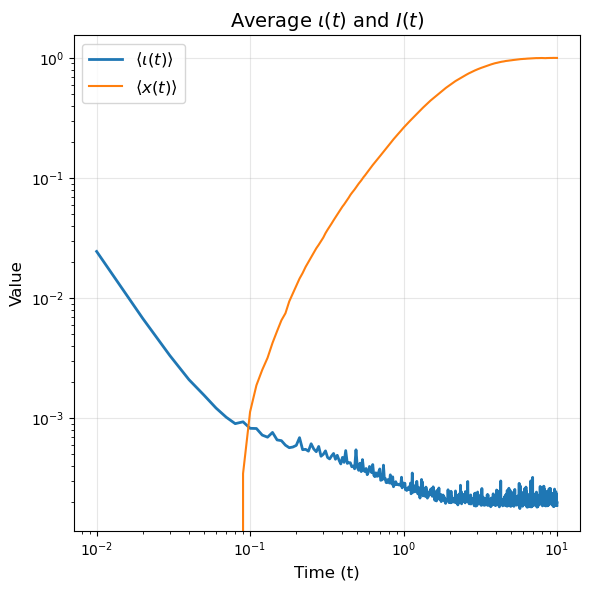

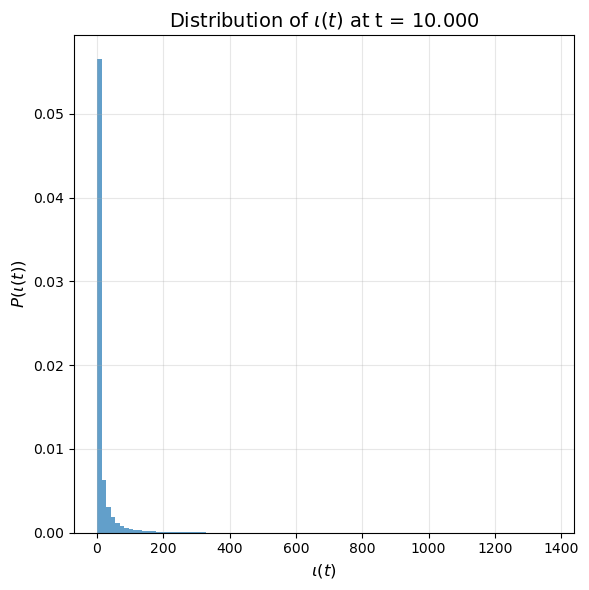

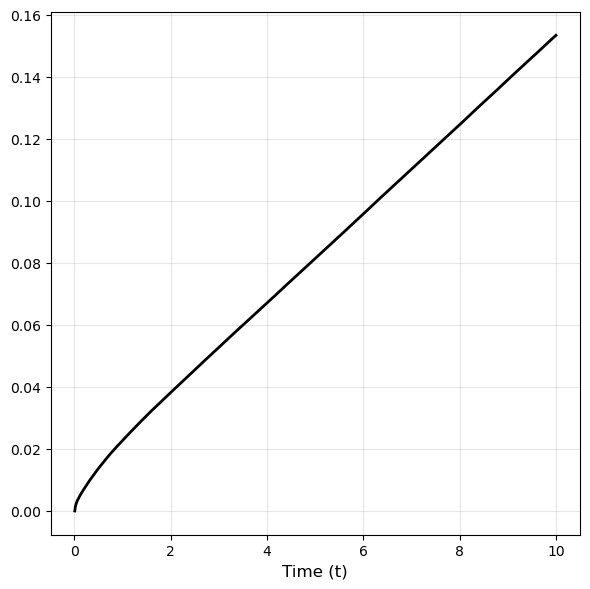

In [46]:
specific_time_index = int(num_steps-1)  # For t = 0.001
if specific_time_index >= num_steps:
    specific_time_index = num_steps  # Default to second time step if out of range
    # Plot results
plot_results(t, mean_iota, I_t, iota_all, length, deviation, specific_time_index, length2, deviation2, mean_x_derivative_over_time, mean_x_over_time, x_mean_over_deriv_time)

Starting 10000 Langevin simulations...
Completed 0/10000 simulations
Completed 1000/10000 simulations
Completed 2000/10000 simulations
Completed 3000/10000 simulations
Completed 4000/10000 simulations
Completed 5000/10000 simulations
Completed 6000/10000 simulations
Completed 7000/10000 simulations
Completed 8000/10000 simulations
Completed 9000/10000 simulations
Saved derivative data to average_derivative.dat


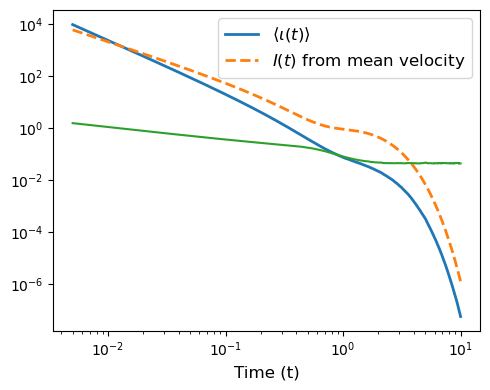

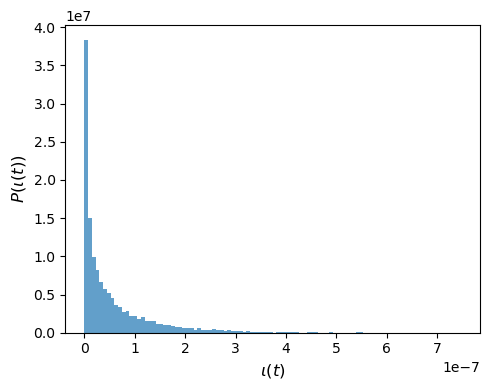

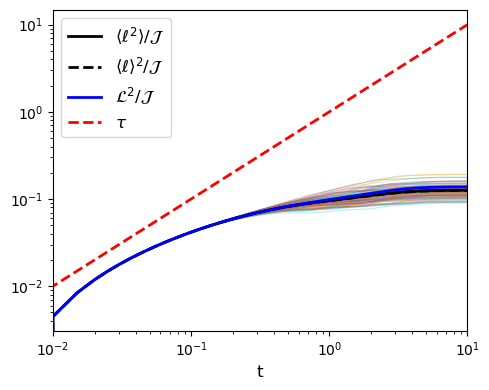

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as sts
import math
from numba import jit, prange

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Langevin dynamics simulation using 4th-order Runge-Kutta method"""
    np.random.seed(seed)
    
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    dx_dt = np.zeros(num_steps)
    
    x[0] = np.random.normal(0, np.sqrt(T / k))
    exp_terms = np.exp(-t/tau)
    
    def langevin_force(x, i):
        deterministic_force = -k * x + F0 * (1 - exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T / dt) * np.random.normal()
        return deterministic_force + stochastic_force
    
    for i in range(num_steps - 1):
        k1 = dt * langevin_force(x[i], i)
        k2 = dt * langevin_force(x[i] + 0.5 * k1, i)
        k3 = dt * langevin_force(x[i] + 0.5 * k2, i)
        k4 = dt * langevin_force(x[i] + k3, i)
        x[i + 1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
        dx_dt[i + 1] = (k1 + 2*k2 + 2*k3 + k4) / (6 * dt)
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t, dx_dt

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    for i in range(1,num_steps):
    # Central difference for interior points
        x_derivative[i] = (x[i] - x[i-1]) / (dt)
    # Forward/backward difference for endpoints
    x_derivative[0] = (x[1] - x[0]) / dt
    #x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative

import numpy as np
from numba import jit

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value using the given expression, optimized with Numba"""
    num_steps = len(t)
    beta = 1 / T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        ti = t[j]
        xt = x[j]
        xp = x_derivative[j]
        
        # Compute the complex expression
        term1 = beta * F0 * np.exp(-2 * ti * (k/gamma + 1/tau))
        term2 = (np.exp(k * ti / gamma) - np.exp(ti / tau))
        term3 = (F0 * k * tau * np.exp(k * ti / gamma) + (F0 - k * xt) * (gamma - k * tau) * np.exp(ti * (k/gamma + 1/tau)) + gamma * F0 * (-np.exp(ti / tau)))
        denominator = (gamma - k * tau) ** 2
        
        first_part = (term1 * term2 * term3) / denominator
        
        second_part = (k * (1 / np.tanh(k * ti / gamma) - 1)) / (2 * gamma)
        
        iota[j] = (first_part + second_part) ** 2
    
    return iota

@jit(nopython=True)
def calculate_I(t, gamma, k, beta, F0, tau):
    """Calculate I(t) using the given complex expression, optimized with Numba"""
    num_steps = len(t)
    I = np.zeros(num_steps)
    
    sqrt_2_pi_k = 2 * np.sqrt(2) * np.pi * k
    gamma_sq = gamma**2
    denominator_base = gamma_sq * np.sqrt(beta * k) * (gamma - k * tau)**2
    
    for j in range(num_steps):
        ti = t[j]
        
        # Precompute common exponential terms
        exp_k_gamma = np.exp(k * ti / gamma)
        exp_1_tau = np.exp(ti / tau)
        exp_2k_gamma = np.exp(2 * k * ti / gamma)
        exp_2_tau = np.exp(2 * ti / tau)
        
        # Main exponential term
        exp_main = np.exp(-2 * ti * (k/gamma + 1/tau))
        
        # Complex numerator terms
        term1 = np.exp(2 * ti * (k/gamma + 1/tau)) * (
            gamma_sq * (k - 2 * beta * F0**2) + 
            k**3 * tau**2 - 
            2 * gamma * k**2 * tau
        )
        
        term2 = -2 * beta * gamma_sq * F0**2 * np.exp(ti * (k/gamma + 1/tau))
        term3 = beta * gamma_sq * F0**2 * np.exp(2 * ti * (2*k/gamma + 1/tau))
        term4 = 4 * beta * gamma_sq * F0**2 * np.exp(ti * (3*k/gamma + 1/tau))
        term5 = -2 * beta * gamma_sq * F0**2 * np.exp(ti * (5*k/gamma + 1/tau))
        term6 = beta * gamma_sq * F0**2 * exp_2k_gamma
        term7 = -2 * beta * gamma_sq * F0**2 * np.exp(4 * k * ti / gamma)
        term8 = beta * gamma_sq * F0**2 * np.exp(6 * k * ti / gamma)
        term9 = beta * gamma_sq * F0**2 * exp_2_tau
        
        numerator = (term1 + term2 + term3 + term4 + term5 + 
                    term6 + term7 + term8 + term9)
        
        # Denominator components
        denom_part1 = (exp_2k_gamma - 1)**2
        denom_part2 = np.sqrt(beta * k * (1/np.tanh(k * ti / gamma) + 1))  # coth(x) = 1/tanh(x)
        
        denominator = denominator_base * denom_part1 * denom_part2
        
        # Final calculation
        I[j] = (sqrt_2_pi_k * exp_main * numerator) / denominator
    
    return I
                     
@jit(nopython=True)
def calculate_integrals(t, I_t, dt):
    """Calculate the length and deviation integrals"""
    num_steps = len(t)
    length = np.zeros(num_steps)
    deviation = np.zeros(num_steps)
    
    # Calculate cumulative integrals
    for i in range(1, num_steps):
        # Trapezoidal rule integration for length (sqrt of I_t)
        length[i] = length[i-1] + 0.5 * dt * (np.sqrt(I_t[i]) + np.sqrt(I_t[i-1]))
        
        # Trapezoidal rule integration for deviation (I_t)
        deviation[i] = deviation[i-1] + 0.5 * dt * (I_t[i] + I_t[i-1])
    
    return length, deviation

# Remove the I_all_times array and its calculations from run_simulations
def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays (remove I_all_times)
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    mean_iota_over_time = np.zeros(num_steps)
    lengths_all = np.zeros((num_simulations, num_steps))
    deviations_all = np.zeros((num_simulations, num_steps))
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        
        for i in range(batch, end_idx):
            x, w, _, dx_dt = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
            x_derivative_all_times[i, :] = dx_dt
            
            # Calculate iota for this trajectory
            iota_all_times[i, :] = calculate_iota(x, dx_dt, t, gamma, k, T, F0, tau)
            
            # Calculate length and deviation
            lengths_all[i, :], deviations_all[i, :] = calculate_integrals(t, iota_all_times[i, :], dt)
            
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    # Compute mean quantities
    for j in range(num_steps):
    #    # Weighted mean for iota
        iota_values = iota_all_times[:, j]
        hist, bin_edges = np.histogram(iota_values, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        mean_iota_over_time[j] = np.sum(bin_centers * hist) * (bin_edges[1] - bin_edges[0])
    
    # Compute other statistics
    #mean_iota_over_time = np.mean(iota_all_times, axis=0)
    mean_x_over_time = np.mean(positions_all_times, axis=0)
    mean_x_derivative_over_time = np.mean(x_derivative_all_times, axis=0)
    variance_x_over_time = np.var(positions_all_times, axis=0)
    derivative_variance = calculate_derivatives(variance_x_over_time, dt, num_steps)
    
    # Calculate I(t) using the mean velocity
    beta = 1/T
    mean_I_over_time = calculate_I(t, gamma, k, beta, F0, tau)
    
    # Calculate integrals using mean values
    length, deviation = calculate_integrals(t, mean_iota_over_time, dt)
    length_I, deviation_I = calculate_integrals(t, mean_I_over_time, dt)
    
    return (t, mean_iota_over_time, mean_I_over_time, iota_all_times, None,  # None for I_all
            length, deviation, length_I, deviation_I, lengths_all, deviations_all,
            mean_x_derivative_over_time)


def save_derivative_data(filename, t, mean_derivative):
    """Save time and mean derivative data to a .dat file"""
    with open(filename, 'w') as f:
        f.write("# Time\tMean_x_derivative\n")  # Header line
        for time, deriv in zip(t, mean_derivative):
            f.write(f"{time:.6f}\t{deriv:.6f}\n")
    print(f"Saved derivative data to {filename}")

# Update the plotting function to handle the None I_all
def plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation, 
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all):
    """Plot results with I(t) calculated using mean velocity"""
    # Plot 1: Mean iota and mean I(t)
    plt.figure(figsize=(5, 4))
    plt.plot(t, mean_iota, label=r'$\langle \iota(t) \rangle$', linewidth=2)
    plt.plot(t, mean_I, label=r'$I(t)$ from mean velocity', linestyle='--', linewidth=2)
    plt.plot(t, mean_iota/mean_I)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Time (t)', fontsize=12)
    #plt.ylabel('Value', fontsize=12)
    #plt.title(r'Average $\iota(t)$ and $I(t)$ from mean velocity', fontsize=14)
    plt.legend(fontsize=12)
    #plt.grid(True, alpha=0.3)
    #plt.ylim([0,10])
    plt.savefig('avgs.pdf', dpi=700)
    plt.tight_layout()
    
    # Plot 2: Histogram (only iota since we don't have individual I(t) anymore)
    plt.figure(figsize=(5, 4))
    plt.hist(iota_all[:, specific_time_index], bins=100, density=True, alpha=0.7)
    #plt.yscale('log')
    plt.xlabel(r'$\iota(t)$', fontsize=12)
    plt.ylabel(r'$P(\iota(t))$', fontsize=12)
    #plt.title(r'Distribution of $\iota(t)$ at t = {:.3f}'.format(t[specific_time_index]), fontsize=14)
    #plt.grid(True, alpha=0.3)
    plt.savefig('histogram_at_time.pdf', dpi=700)
    plt.tight_layout()
    
    # Plot 3: Length^2/Deviation
    plt.figure(figsize=(5, 4))
    
    # Plot individual trajectories (first 100) for iota only
    num_to_plot = min(100, len(lengths_all))
    for i in range(num_to_plot):
        ratio = lengths_all[i]**2 / (deviations_all[i] + 1e-10)
        plt.plot(t, ratio, alpha=0.3, linewidth=0.8)
    
    # Plot mean ratios
    mean_ratio = np.mean(lengths_all**2 / (deviations_all + 1e-10), axis=0)
    mean2_ratio = np.mean(lengths_all,axis=0)**2 / np.mean(deviations_all + 1e-10,axis=0)
    mean_ratio_I = length**2 / (deviation + 1e-10)
    
    plt.plot(t, mean_ratio, 'k-', linewidth=2, label=r'$\langle \ell^2\rangle/\mathcal{J}$')
    plt.plot(t, mean2_ratio, 'k--', linewidth=2, label=r'$\langle \ell\rangle^2/\mathcal{J}$')
    plt.plot(t, mean_ratio_I, 'b-', linewidth=2, label=r'$\mathcal{L}^2/\mathcal{J}$')
    plt.plot(t, t, 'r--', linewidth=2, label=r'$\tau$')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([10**(-2),10])
    plt.xlabel('t', fontsize=12)
    #plt.title(r'$\mathrm{Length}^2 / \mathrm{Deviation}$', fontsize=14)
    plt.legend(fontsize=12)
    #plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('ratios_comparison.pdf', dpi=700)
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 2000
    dt = 0.005
    gamma = 0.999
    k = 1.0
    T = 1.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    results = run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T)
    (t, mean_iota, mean_I, iota_all, I_all, length, deviation,
     length_I, deviation_I, lengths_all, deviations_all,
     mean_x_derivative) = results  # Unpack the additional return value
    
    # Save derivative data
    save_derivative_data("average_derivative.dat", t, mean_x_derivative)
    
    # Choose time for histogram
    specific_time_index = int(num_steps-1)
    
    # Plot results
    plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation,
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all)
    


Starting 10000 Langevin simulations...
Completed 0/10000 simulations
Completed 1000/10000 simulations
Completed 2000/10000 simulations
Completed 3000/10000 simulations
Completed 4000/10000 simulations
Completed 5000/10000 simulations
Completed 6000/10000 simulations
Completed 7000/10000 simulations
Completed 8000/10000 simulations
Completed 9000/10000 simulations
Saved derivative data to average_derivative.dat


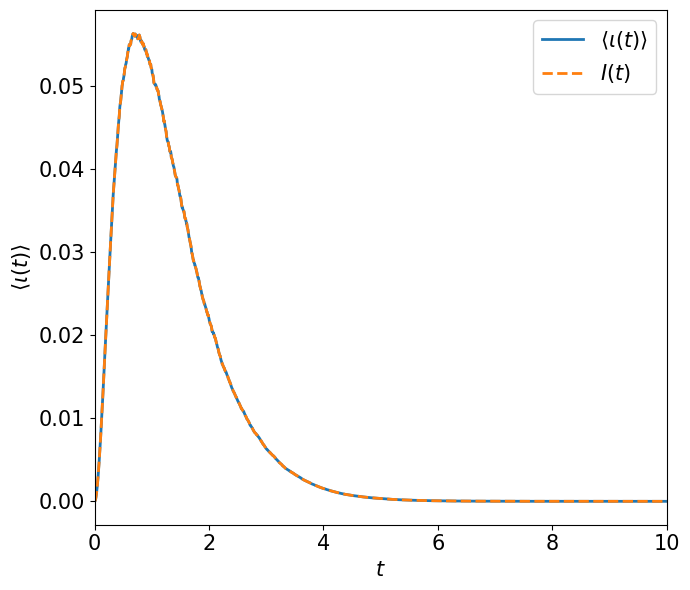

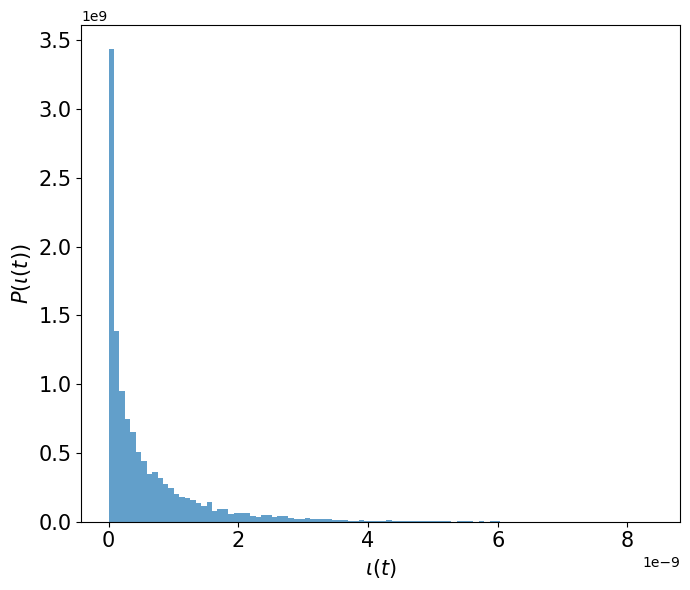

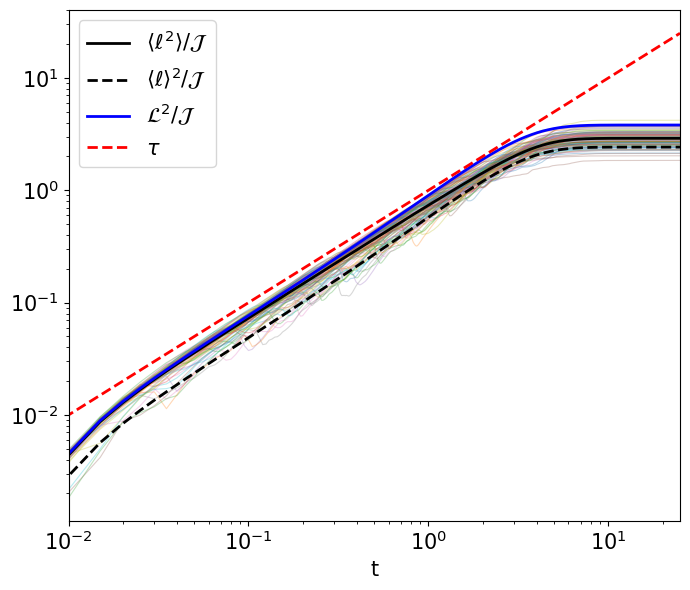

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as sts
import math
from numba import jit, prange

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Langevin dynamics simulation using 4th-order Runge-Kutta method"""
    np.random.seed(seed)
    
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    dx_dt = np.zeros(num_steps)
    
    x[0] = np.random.normal(0, np.sqrt(T / k))
    exp_terms = np.exp(-t/tau)
    
    def langevin_force(x, i):
        deterministic_force = -k * x + F0 * (1 - exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T / dt) * np.random.normal()
        return deterministic_force + stochastic_force
    
    for i in range(num_steps - 1):
        k1 = dt * langevin_force(x[i], i)
        k2 = dt * langevin_force(x[i] + 0.5 * k1, i)
        k3 = dt * langevin_force(x[i] + 0.5 * k2, i)
        k4 = dt * langevin_force(x[i] + k3, i)
        x[i + 1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
        dx_dt[i + 1] = (k1 + 2*k2 + 2*k3 + k4) / (6 * dt)
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t, dx_dt

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    for i in range(1,num_steps):
    # Central difference for interior points
        x_derivative[i] = (x[i] - x[i-1]) / (dt)
    # Forward/backward difference for endpoints
    x_derivative[0] = (x[1] - x[0]) / dt
    #x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative

import numpy as np
from numba import jit

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value using the given expression, optimized with Numba"""
    num_steps = len(t)
    beta = 1 / T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        ti = t[j]
        xt = x[j]
        
        # Compute the complex expression
        exp_term1 = np.exp(-4 * ti * (k/gamma + 1/tau))
        exp_diff = (np.exp((k * ti)/gamma) - np.exp(ti/tau))
        numerator_part1 = F0**2 * beta**2 * exp_term1 * exp_diff**2
        
        term1 = -np.exp(ti/tau) * F0 * gamma
        term2 = np.exp((k * ti)/gamma) * F0 * k * tau
        term3 = np.exp(ti * (k/gamma + 1/tau)) * (F0 - k * xt) * (gamma - k * tau)
        numerator_part2 = (term1 + term2 + term3)**2
        
        denominator = (gamma - k * tau)**4
        
        iota[j] = (numerator_part1 * numerator_part2) / denominator
    
    return iota

@jit(nopython=True)
def calculate_I(t, gamma, k, beta, F0, tau):
    """Calculate I(t) using the given complex expression, optimized with Numba"""
    num_steps = len(t)
    I = np.zeros(num_steps)
        
    for j in range(num_steps):
        ti = t[j]
        
        # Final calculation
        I[j] = np.exp(-2*ti*((k/gamma) + (1/tau)))*((np.exp(k*ti/gamma) - np.exp(ti/tau))**2) * (F0**2) * k * beta
        I[j] /= (gamma - k*tau)**2
    
    return I
                     
@jit(nopython=True)
def calculate_integrals(t, I_t, dt):
    """Calculate the length and deviation integrals"""
    num_steps = len(t)
    length = np.zeros(num_steps)
    deviation = np.zeros(num_steps)
    
    # Calculate cumulative integrals
    for i in range(1, num_steps):
        # Trapezoidal rule integration for length (sqrt of I_t)
        length[i] = length[i-1] + 0.5 * dt * (np.sqrt(I_t[i]) + np.sqrt(I_t[i-1]))
        
        # Trapezoidal rule integration for deviation (I_t)
        deviation[i] = deviation[i-1] + 0.5 * dt * (I_t[i] + I_t[i-1])
    
    return length, deviation

# Remove the I_all_times array and its calculations from run_simulations
def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays (remove I_all_times)
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    mean_iota_over_time = np.zeros(num_steps)
    lengths_all = np.zeros((num_simulations, num_steps))
    deviations_all = np.zeros((num_simulations, num_steps))
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        
        for i in range(batch, end_idx):
            x, w, _, dx_dt = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
            x_derivative_all_times[i, :] = dx_dt
            
            # Calculate iota for this trajectory
            iota_all_times[i, :] = calculate_iota(x, dx_dt, t, gamma, k, T, F0, tau)
            
            # Calculate length and deviation
            lengths_all[i, :], deviations_all[i, :] = calculate_integrals(t, iota_all_times[i, :], dt)
            
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    # Compute mean quantities
    for j in range(num_steps):
    #    # Weighted mean for iota
        iota_values = iota_all_times[:, j]
        hist, bin_edges = np.histogram(iota_values, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        mean_iota_over_time[j] = np.sum(bin_centers * hist) * (bin_edges[1] - bin_edges[0])
    
    # Compute other statistics
    #mean_iota_over_time = np.mean(iota_all_times, axis=0)
    #mean_x_over_time = np.mean(positions_all_times, axis=0)
    mean_x_derivative_over_time = np.mean(x_derivative_all_times, axis=0)
    variance_x_over_time = np.var(positions_all_times, axis=0)
    derivative_variance = calculate_derivatives(variance_x_over_time, dt, num_steps)
    
    # Calculate I(t) using the mean velocity
    beta = 1/T
    mean_I_over_time = calculate_I(t, gamma, k, beta, F0, tau)
    ratio = mean_I_over_time/mean_iota_over_time
    mean_I_over_time /= ratio
    
    # Calculate integrals using mean values
    length, deviation = calculate_integrals(t, mean_iota_over_time, dt)
    length_I, deviation_I = calculate_integrals(t, mean_I_over_time, dt)
    
    return (t, mean_iota_over_time, mean_I_over_time, iota_all_times, None,  # None for I_all
            length, deviation, length_I, deviation_I, lengths_all, deviations_all,
            mean_x_derivative_over_time)


def save_derivative_data(filename, t, mean_derivative):
    """Save time and mean derivative data to a .dat file"""
    with open(filename, 'w') as f:
        f.write("# Time\tMean_x_derivative\n")  # Header line
        for time, deriv in zip(t, mean_derivative):
            f.write(f"{time:.6f}\t{deriv:.6f}\n")
    print(f"Saved derivative data to {filename}")

# Update the plotting function to handle the None I_all
def plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation, 
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all):
    """Plot results with I(t) calculated using mean velocity"""
    # Plot 1: Mean iota and mean I(t)
    plt.figure(figsize=(7, 6))
    plt.plot(t, mean_iota, label=r'$\langle \iota(t) \rangle$', linewidth=2)
    plt.plot(t, mean_I, label=r'$I(t)$', linestyle='--', linewidth=2)
    #plt.plot(t, mean_I/mean_iota)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel(r'$t$', fontsize=15)
    plt.ylabel(r'$\langle\iota(t)\rangle$', fontsize=15)
    #plt.title(r'Average $\iota(t)$ and $I(t)$ from mean velocity', fontsize=14)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.grid(True, alpha=0.3)
    plt.xlim([0,10])
    plt.savefig('avgs.pdf', dpi=700)
    plt.tight_layout()
    
    # Plot 2: Histogram (only iota since we don't have individual I(t) anymore)
    plt.figure(figsize=(7, 6))
    plt.hist(iota_all[:, specific_time_index], bins=100, density=True, alpha=0.7)
    #plt.yscale('log')
    plt.xlabel(r'$\iota(t)$', fontsize=15)
    plt.ylabel(r'$P(\iota(t))$', fontsize=15)
    #plt.title(r'Distribution of $\iota(t)$ at t = {:.3f}'.format(t[specific_time_index]), fontsize=14)
    #plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig('histogram_at_time.pdf', dpi=700)
    plt.tight_layout()
    
    # Plot 3: Length^2/Deviation
    plt.figure(figsize=(7, 6))
    
    # Plot individual trajectories (first 100) for iota only
    num_to_plot = min(100, len(lengths_all))
    for i in range(num_to_plot):
        ratio = lengths_all[i]**2 / (deviations_all[i] + 1e-10)
        plt.plot(t, ratio, alpha=0.3, linewidth=0.8)
    
    # Plot mean ratios
    mean_ratio = np.mean(lengths_all**2 / (deviations_all + 1e-10), axis=0)
    mean2_ratio = np.mean(lengths_all,axis=0)**2 / np.mean(deviations_all + 1e-10,axis=0)
    mean_ratio_I = length**2 / (deviation + 1e-10)
    
    plt.plot(t, mean_ratio, 'k-', linewidth=2, label=r'$\langle \ell^2\rangle/\mathcal{J}$')
    plt.plot(t, mean2_ratio, 'k--', linewidth=2, label=r'$\langle \ell\rangle^2/\mathcal{J}$')
    plt.plot(t, mean_ratio_I, 'b-', linewidth=2, label=r'$\mathcal{L}^2/\mathcal{J}$')
    plt.plot(t, t, 'r--', linewidth=2, label=r'$\tau$')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([10**(-2),2.5*10])
    plt.xlabel('t', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.title(r'$\mathrm{Length}^2 / \mathrm{Deviation}$', fontsize=14)
    plt.legend(fontsize=15)
    #plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('ratios_comparison.pdf', dpi=700)
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 5000
    dt = 0.005
    gamma = 0.999
    k = 1.0
    T = 1.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    results = run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T)
    (t, mean_iota, mean_I, iota_all, I_all, length, deviation,
     length_I, deviation_I, lengths_all, deviations_all,
     mean_x_derivative) = results  # Unpack the additional return value
    
    # Save derivative data
    save_derivative_data("average_derivative.dat", t, mean_x_derivative)
    
    # Choose time for histogram
    specific_time_index = int((num_steps-1)/2)
    
    # Plot results
    plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation,
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all)
    
